# Анализ данных сервиса аренды самокатов GoFast

**Цель исследования:**
Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти

**Ход исследования:**

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 
Сервисом можно пользоваться:
1. без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

В основных данных есть информация о пользователях, их поездках и подписках.
Для начала проведу обзор данных по каждому датафрейму. Далее, будем делать предобработку данных. Искать аномалии, пропущенные значения и т.д.

Из полученных данных исследую и проведу анализ таких показателей как:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

Для решения поставленных задач необходимо будет:
- объединить данные о пользователях, поездках и подписках в один датафрейм
- создать ещё два датафрейма из датафрейма (c данными о пользователях без подписки и с данными о пользователях с подпиской)
- создать датафрейм с агрегированными данными о поездках
- добавить столбец с помесячной выручкой, которую принёс каждый пользователь
- проверить 3 гипотезы:
1. тратят ли пользователи с подпиской больше времени на поездки?
2. можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
3. будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки


**Таким образом, исследование пройдёт в 7 этапов:**
- Обзор данных.
- Предобработка данных.
- Исследовательский анализ данных
- Объединение данных
- Подсчет выручки
- Проверка гипотез
- Выводы

## Этап 1. Обзор данных

Импортируем библиотеки

In [1]:
import pandas as pd
import math 
from math import factorial 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

Прочитаем и рассмотрим датафрейм **Пользователи**

In [2]:
try:
    df_users = pd.read_csv('/datasets/users_go.csv')
except:
    df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Формат данных корректный, стилистика столбцов не нарушена.

Выведем первые строки.

In [4]:
df_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Рассмотрим сводную статистику возрастных значений датафрейма

In [5]:
df_users['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Видим, что минимальный возраст пользователя 12 лет, а максимальный возраст не превышает 43-х лет. Среднее и медиана 25 лет точны.

Рассмотрим распределение всех пользователей по городам. 

In [6]:
df_users['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

Больше всего пользователей из Пятигорска, меньше всех из Москвы. В остальных городах пользователи распределны почти равномерно.

Рассмотрим как распределены пользователи в зависимости от тарифа (free, ultra)

In [7]:
df_users['subscription_type'].value_counts()

free     846
ultra    719
Name: subscription_type, dtype: int64

Больше всего пользователей с бесплатной подпиской.

Прочитаем и рассмотрим датафрейм **Поездки**

In [8]:
try:
    df_rides = pd.read_csv('/datasets/rides_go.csv')
except:
    df_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [9]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Формат данных в столбце date не корректный, стилистика столбцов не нарушена.

Выведем первые строки.

In [10]:
df_rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [11]:
df_rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Установим топ-5 пользователей по колличеству  поездок

In [12]:
df_rides['user_id'].value_counts().sort_values(ascending=False).head()

1236    27
1063    26
783     26
1204    24
1149    23
Name: user_id, dtype: int64

Пользователь с id-1236 совершил больше всех поездок - 27 шт.

Установим топ-10 пользователей с максимальной общей дистанцией проведенной в поездках

In [13]:
df_rides.groupby(['user_id']).sum().sort_values(by='distance', ascending=False).head(10)

,distance,duration
user_id,,
1063,79325.846482,440.533761
1236,78744.976586,446.233013
1361,77773.501423,408.979310
1468,77392.080789,429.513327
1374,74901.673366,394.418821
895,74266.723567,417.896744
1204,72873.754697,432.153686
1383,71564.205631,401.388850
1217,71525.424486,355.845697


Пользователь с id-1063 проехал в сумме дистанцию 79,3 км за общее время примерно 7 часов. 

Прочитаем и рассмотрим датафрейм **Подписки**

In [14]:
try:
    df_sub = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    df_sub = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [15]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Формат данных корректный, стилистика столбцов не нарушена.


In [16]:
df_sub

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Данные по подпискам совпадают с заявленными

### Вывод

Прочитали и рассмотрели данные из трех датафреймов.

- Возраст пользователей аренды самокатов от 12 до 43 лет, средний возраст пользователя  - 25 лет.
- Распределение пользователей по городам +- одинаковое (больше всего пользователей из Пятигорска, меньше из Москвы)
- Чуть больше пользователей с бесплатным тарифом 
- Есть недочет в формате данных столбца date, займемся им на следующем этапе

## Этап 2. Предобработка данных

Проверим пропуски в таблицах

In [17]:
df_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [18]:
df_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [19]:
df_sub.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Приведем к типу даты уже ранее замеченный не корректный формат столбеца date из датафрейма df_rides

In [20]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format = '%Y-%m-%d')
df_rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Создадим новый столбец с номером месяца на основе столбца date

In [21]:
df_rides['month'] = df_rides['date'].dt.month
df_rides.sample(10)

,user_id,distance,duration,date,month
6609,707,3223.172899,17.408277,2021-08-05,8
14662,1291,3044.643196,17.133930,2021-10-23,10
3117,336,2892.182864,11.676549,2021-03-04,3
17372,1486,2696.624579,12.778481,2021-12-26,12
14100,1252,3524.979584,20.134568,2021-05-07,5
17199,1474,3876.708827,24.892502,2021-02-27,2
2965,318,3069.466404,16.673666,2021-11-06,11
8144,821,3643.891645,18.808339,2021-06-24,6
1749,189,2617.392966,9.543482,2021-06-09,6
5785,616,3183.347290,16.095278,2021-08-07,8


Рассмотрим явные дубликаты в таблицах Пользователи и Поездки

In [22]:
df_users.duplicated().sum()

31

Удаляем явные дубликаты

In [23]:
df_users.drop_duplicates(inplace=True)
df_users.duplicated().sum()

0

Так же проверим дубликаты по сумме ключевых параметров (подмножеству)

In [24]:
duplicate_users = df_users[df_users.duplicated(['user_id'])]
duplicate_users

,user_id,name,age,city,subscription_type


In [25]:
duplicate_users_n = df_users[df_users.duplicated(['user_id', 'subscription_type'])]
duplicate_users_n 

,user_id,name,age,city,subscription_type


In [26]:
df_rides.duplicated().sum()

0

### Вывод
Предобработка данных совершена успешно:
- пропущенных данных в таблицах нет
- привели столбец date в корректный формат
- добавили столбец month с номером месяца
- удалили строки-дубликаты в пользователях

## Этап 3. Исследовательский анализ данных

### 3.1 частота встречаемости городов

Рассмотрим распределение всех пользователей по городам

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

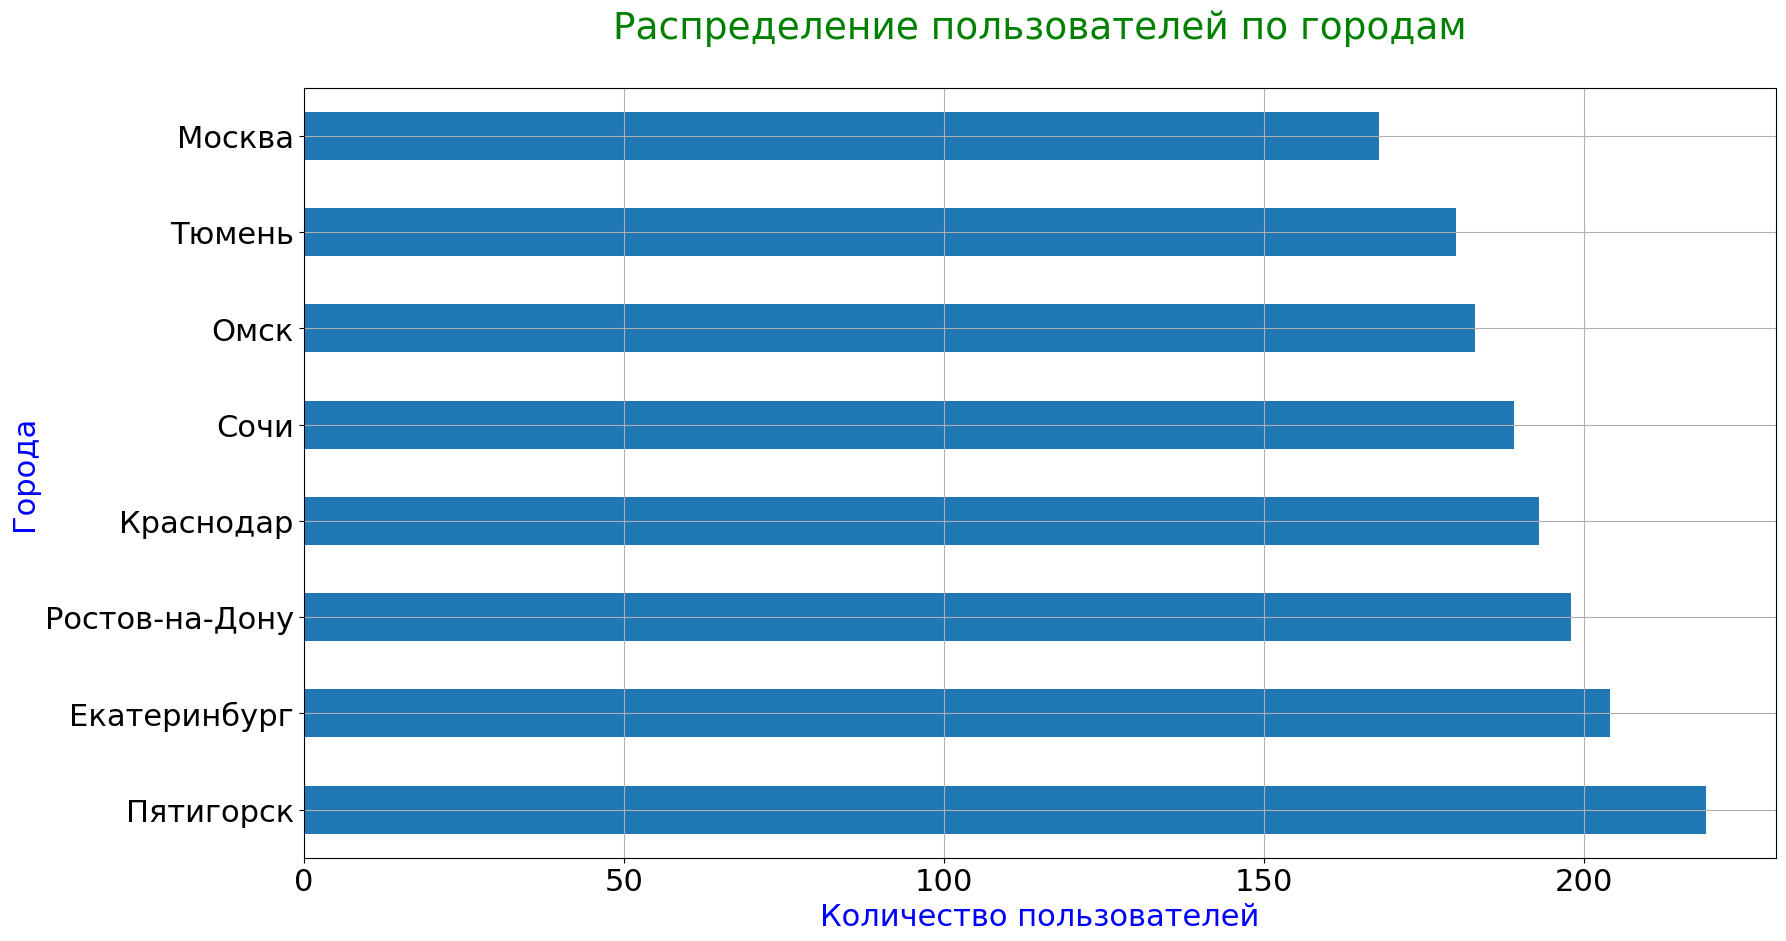

In [27]:
df_users['city'].value_counts().plot(
    kind = 'barh',
    figsize = (19,10), 
    legend = False, 
    fontsize = 22,  
    grid=True,
)
plt.title('Распределение пользователей по городам' + "\n", fontsize=27, color='Green')
plt.xlabel('Количество пользователей', fontsize=22, color='Blue')
plt.ylabel('Города', fontsize=22, color='Blue')

df_users['city'].value_counts()

Больше всего пользователей из Пятигорска, не значительно но всё-таки меньше всех из Москвы. В остальных городах пользователи распределны равномерно. Такая картина подтверждает что выборка репрезентативна. 

### 3.2 соотношение пользователей с подпиской и без подписки

Рассмотрим как распределны пользователи в зависимости от выбранного тарифа (free, ultra)

free     835
ultra    699
Name: subscription_type, dtype: int64

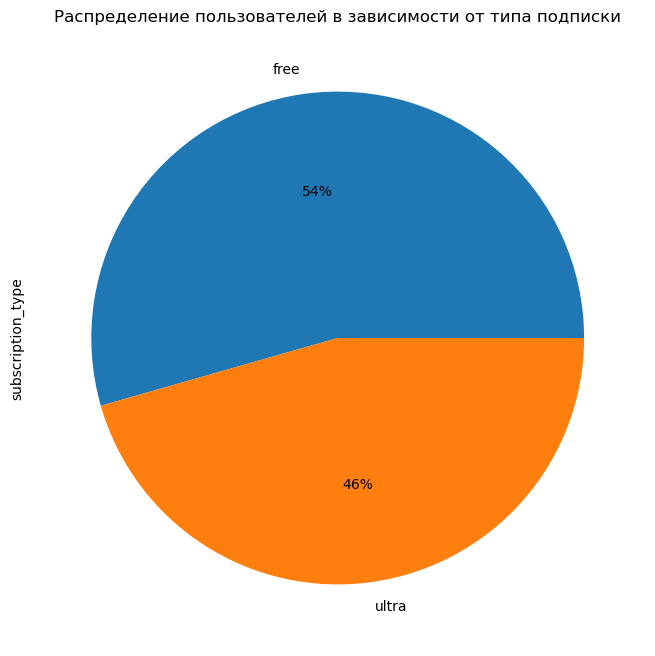

In [28]:
df_users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    autopct = '%1.0f%%', 
    figsize=(8,8),
    title = 'Распределение пользователей в зависимости от типа подписки'
)

df_users['subscription_type'].value_counts()

Пользователей, не использующих подписку больше - 835 человек, что является 54% от общего числа пользователей.

На платной подписке ultra 699 пользователей, что соответственно является 46%.

### 3.3 возраст пользователей

Рассмотрим средние, максимальные и минимальные значения

In [29]:
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Самому страшему пользователю 43 года, самому младшему 12 лет. Медиана и среднее точны - средний возраст пользователя - 25 лет.

Наглядно рассмотрим разброс возраста всех пользователей. Для этого построим гистограмму.

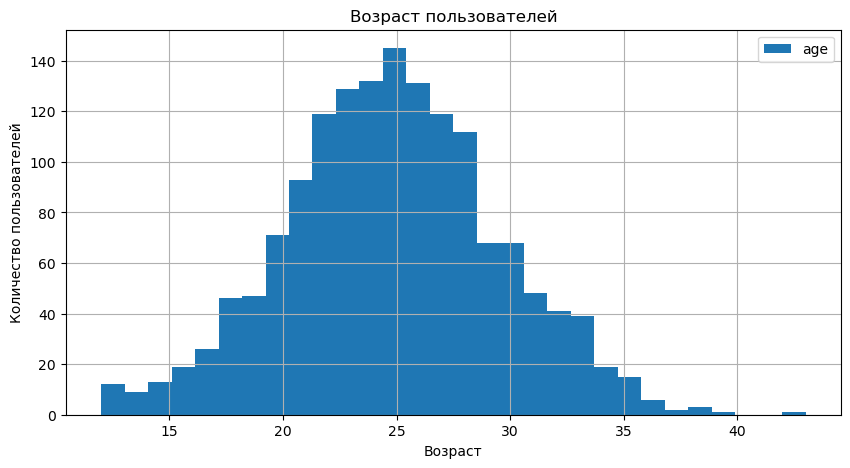

In [30]:
df_users['age'].hist(bins=30, figsize=(10, 5), legend=True, grid=True)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

Основной возраст пользователей 20-30 лет. Средний и самый распространенный возраст - 25 лет.

### 3.4 расстояние, которое пользователь преодолел за одну поездку

Рассмотрим средние, максимальные и минимальные значения

In [31]:
df_rides['distance'].describe().round(2)

count    18068.00
mean      3070.66
std       1116.83
min          0.86
25%       2543.23
50%       3133.61
75%       3776.22
max       7211.01
Name: distance, dtype: float64

Самая длинная поездка  - 7,2 км, самая короткая - меньше метра :) 

Топ-10 саммых длинных расстояний за одну поездку

In [32]:
df_rides['distance'].sort_values(ascending=False).head(10).round(2)

16309    7211.01
16484    7066.00
15580    6908.49
17171    6760.94
17242    6724.93
10341    6671.97
11385    6601.20
12086    6538.94
10915    6535.39
11319    6503.60
Name: distance, dtype: float64

Топ-10 саммых коротких расстояний за одну поездку

In [33]:
df_rides['distance'].sort_values().head(10).round(2)

11555     0.86
9541      2.57
13690     4.33
8658      6.78
7841      7.10
8906     11.28
8324     12.23
13940    15.00
15626    15.37
11862    15.63
Name: distance, dtype: float64

Самая короткая дистанция меньше метра, это подозрительно, но скорее всего связано с тем что пользователь передумал брать самокат, либо самокат оказался неисправным.

Для визуализации расстояния, которое пользователь преодолел за одну поездку построим диаграмму размаха

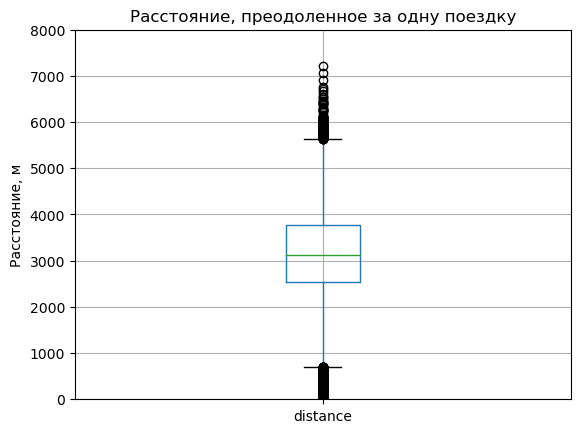

In [34]:
df_rides.boxplot(column='distance')
plt.ylim(0, 8000)
plt.title('Расстояние, преодоленное за одну поездку')
plt.ylabel('Расстояние, м')
plt.show()

В основном все пользователи проезжают дистанцию от 2,5 до 3,8 км.

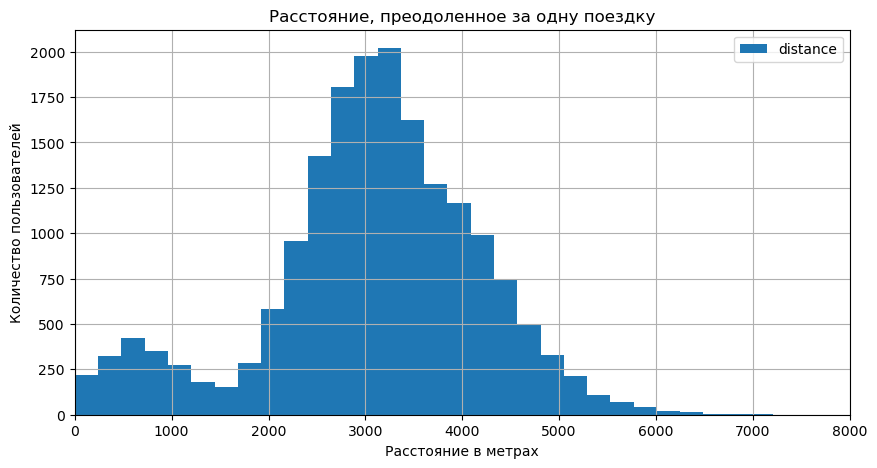

In [35]:
df_rides['distance'].hist(bins=30, figsize=(10, 5), legend=True, grid=True)
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlim(0, 8000)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.show()

### 3.5 продолжительность поездок

Рассмотрим средние, максимальные и минимальные значения

In [36]:
df_rides['duration'].describe().round(2)

count    18068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64

Самая долгая поездка - 41 минута, самая короткая - 30 секунд

Топ-10 самых длительных поездок

In [37]:
df_rides['duration'].sort_values(ascending=False).head(10).round(1)

4215    40.8
4709    39.9
2623    39.5
1998    38.4
6453    38.3
143     38.1
3729    37.0
499     36.9
6348    36.8
4653    36.6
Name: duration, dtype: float64

Топ-10 самых быстрых поездок

In [38]:
df_rides['duration'].sort_values().head(10).round(1)

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
15015    0.5
13012    0.5
7508     0.5
16589    0.5
9049     0.5
Name: duration, dtype: float64

Достаточно много поездок по 30 секунд, это подозрительно, но скорее всего связано с тем что пользователь передумал брать самокат, либо самокат оказался неисправным.

Для визуализации продолжительности поездок построим диаграмму размаха

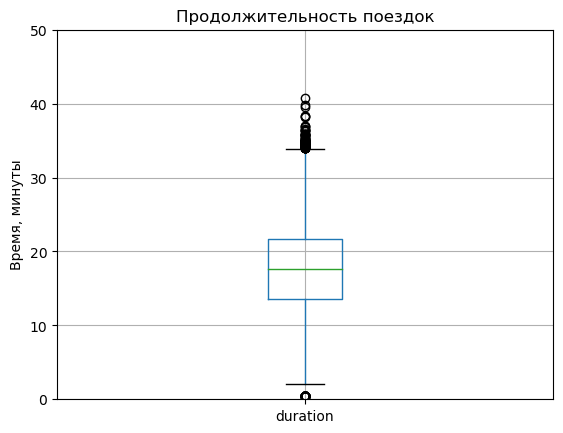

In [39]:
df_rides.boxplot(column='duration')
plt.ylim(0, 50)
plt.title('Продолжительность поездок')
plt.ylabel('Время, минуты')
plt.show()

В основном продолжительность поездки составляет от 14 до 22 минут 

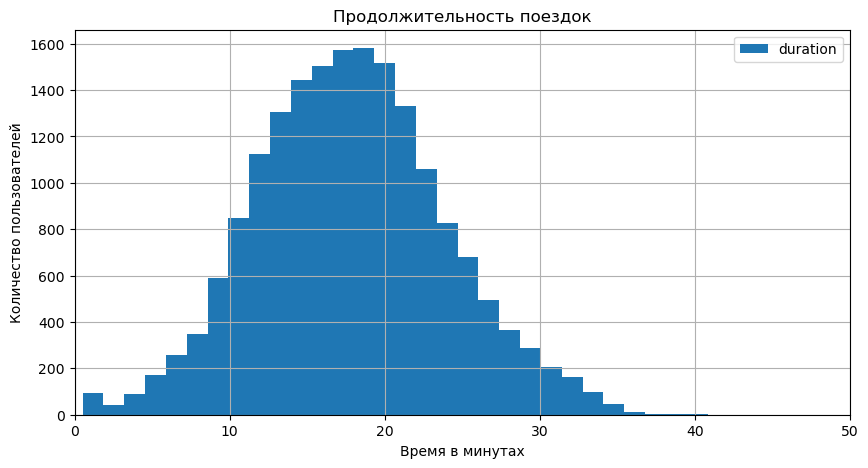

In [40]:
df_rides['duration'].hist(bins=30, figsize=(10, 5), legend=True, grid=True)
plt.title('Продолжительность поездок')
plt.xlim(0, 50)
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.show()

Я бы под корректировала вывод и сказала, что в основном продолжительность поездки составляет от 10 до 25 минут 

### Вывод

3.1 Количество пользователей по городам распределено примерно одинаково.

Лидером по количеству пользователей является Пятигорск - 219 пользователей. 

Меньше всего пользователей в Москве - 168. 

Связано это скорее всего с тем, что Пятигорск по размерам в несколько раз меньше Москвы, т.е. в Пятигорске удобнее брать самокат, чтобы куда-то добраться.

3.2 Пользователей, использующих бесплатную подписку больше - 835 человек, что является 54% от общего числа пользователей. 

На платной подписке 699 пользователей, что соответственно является 46%.

3.3 Самому страшему пользователю 43 года.

Самому младшему 12 лет. 

Средний возраст пользователя - 25 лет.

В целом, пользователи приложения укладываются в промежуток от 20 до 30 лет.

3.4 Самая короткая дистанция - 0.86 м., это подозрительно, но скорее всего связано с тем что пользователь передумал брать самокат, либо самокат оказался неисправным.

Самая длинная - 7.2 км

В основном пользователи проезжают от 2.5 км до 3,8 км.

3.5 Самые короткие поездки - по пол минуты, но скорее всего связано с тем что пользователь передумал брать самокат, либо самокат оказался неисправным.

Самая длинная поездка заняла 41 минуту.

В целом же продолжительность поездки состовляет 10 - 25 минут.

## Этап 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [41]:
df=df_users.merge(df_rides)
df=df.merge(df_sub)
df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [42]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [43]:
df_users.shape

(1534, 5)

In [44]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [45]:
df_rides.shape

(18068, 5)

In [46]:
df_rides['user_id'].value_counts()

1236    27
783     26
1063    26
1204    24
1149    23
        ..
354      3
139      3
567      3
342      2
366      2
Name: user_id, Length: 1534, dtype: int64

У датафреймов df_users и df_rides общий столбец 'user_id', количество уникальных значений этого солбца совпадает, поэтому объединение пройдет корректно. 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [48]:
df.shape

(18068, 12)

Число строк df_rides и общей созданной таблицы df совпадает. Типы данных отображены корректно.

In [49]:
df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков не обнаружено

In [50]:
df.duplicated().sum()

0

Дубликаты отсутсвуют.

Создадим датафрейм c данными о пользователях без подписки (free)

In [51]:
df_free_sub = df.query("subscription_type == 'free'")
df_free_sub.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
11316,1052,Вячеслав,27,Пятигорск,free,3925.431410,20.084771,2021-05-15,5,8,50,0
15343,1342,Данила,23,Тюмень,free,672.131419,8.680329,2021-06-29,6,8,50,0
8286,832,Анна,24,Омск,free,808.117021,15.939481,2021-03-26,3,8,50,0
17444,1491,Адель,31,Сочи,free,3751.509757,22.003623,2021-06-08,6,8,50,0
14688,1293,Ксения,23,Омск,free,2943.702328,22.831107,2021-12-13,12,8,50,0
13632,1219,Ксения,25,Пятигорск,free,4747.751035,27.565003,2021-07-09,7,8,50,0
11816,1088,Самир,28,Тюмень,free,3390.879623,25.495707,2021-06-28,6,8,50,0
14020,1246,Максим,22,Тюмень,free,4240.583645,15.785962,2021-09-26,9,8,50,0
13048,1179,Анна,24,Сочи,free,397.452492,3.135579,2021-03-27,3,8,50,0
10837,1017,Марина,25,Екатеринбург,free,3974.972796,18.949946,2021-03-12,3,8,50,0


Создадим датафрейм c данными о пользователях с подпиской (ultra)

In [52]:
df_ultra_sub = df.query("subscription_type == 'ultra'")
df_ultra_sub.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
5212,560,Самир,33,Москва,ultra,2816.341961,13.499251,2021-09-06,9,6,0,199
3959,426,Татьяна,20,Омск,ultra,3514.528273,31.170154,2021-06-30,6,6,0,199
4862,524,Екатерина,19,Сочи,ultra,4893.098845,31.583533,2021-04-22,4,6,0,199
71,7,Игорь,23,Омск,ultra,3462.821146,10.695158,2021-01-20,1,6,0,199
6462,694,Алия,29,Краснодар,ultra,2875.683485,13.783813,2021-11-11,11,6,0,199
6102,654,Самира,26,Пятигорск,ultra,2683.460244,14.192601,2021-07-26,7,6,0,199
2609,277,Валерий,18,Екатеринбург,ultra,4968.463606,21.550355,2021-02-04,2,6,0,199
2745,293,Агата,26,Краснодар,ultra,3654.157115,17.180524,2021-01-30,1,6,0,199
5864,624,Рустам,26,Ростов-на-Дону,ultra,2821.613065,12.270251,2021-10-25,10,6,0,199
1610,173,Никита,23,Екатеринбург,ultra,3790.422915,23.214086,2021-05-02,5,6,0,199


**Визуализируем информацию о расстоянии поездок для пользователей с подпиской и без нее**

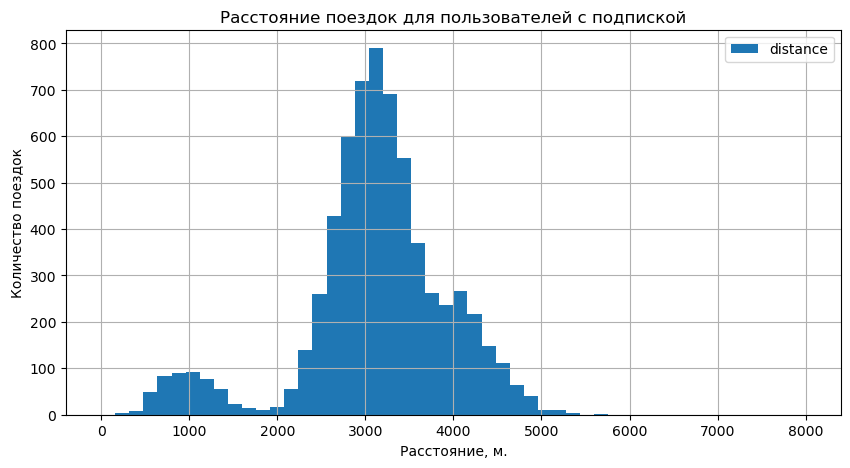

count    6500.00
mean     3115.45
std       836.90
min       244.21
25%      2785.44
50%      3148.64
75%      3560.57
max      5699.77
Name: distance, dtype: float64

In [53]:
df_ultra_sub['distance'].hist(bins=50, range = (0, 8000), figsize=(10, 5), legend=True, grid=True)
plt.title('Расстояние поездок для пользователей с подпиской')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество поездок')
plt.show()

df_ultra_sub['distance'].describe().round(2)

Дистанция поездок у пользователей с подпиской в основном 2.5-4.5 км. Максимальная дистанция 5.7 км, минимальная - 244 метра. Среднее и медиана практически точны - 3.1 км. 

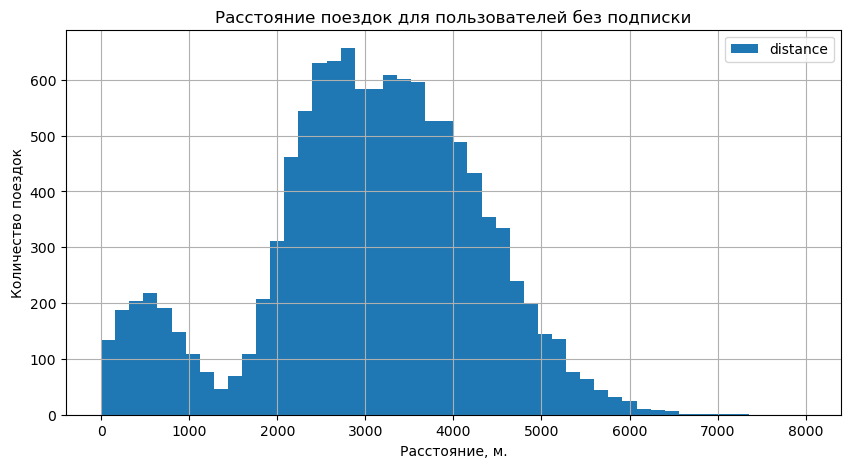

count    11568.00
mean      3045.50
std       1246.17
min          0.86
25%       2366.56
50%       3114.65
75%       3905.70
max       7211.01
Name: distance, dtype: float64

In [54]:
df_free_sub['distance'].hist(bins=50, range = (0, 8000), figsize=(10, 5), legend=True, grid=True)
plt.title('Расстояние поездок для пользователей без подписки')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество поездок')
plt.show()

df_free_sub['distance'].describe().round(2)

Дистанция поездок у пользователей без подписки в основном 1.7-5 км. Максимальная дистанция 7.2 км, минимальная меньше метра. Среднее и медиана практически точны - 3 км.

**Визуализируем информацию о продолжительности поездок для пользователей с подпиской и без нее**

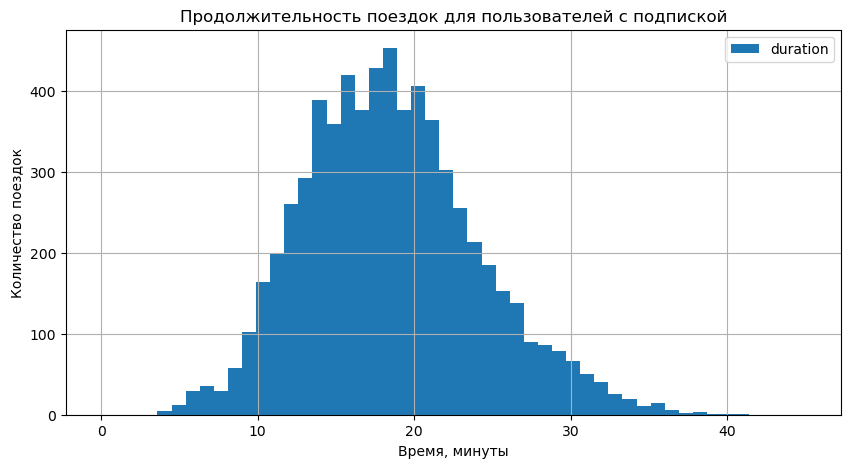

count    6500.0
mean       18.5
std         5.6
min         3.8
25%        14.5
50%        18.2
75%        21.9
max        40.8
Name: duration, dtype: float64

In [55]:
df_ultra_sub['duration'].hist(bins=50, range = (0, 45), figsize=(10, 5), legend=True, grid=True)
plt.title('Продолжительность поездок для пользователей с подпиской')
plt.xlabel('Время, минуты')
plt.ylabel('Количество поездок')
plt.show()

df_ultra_sub['duration'].describe().round(1)

Продолжительность поездок пользователей с подпиской в основном 10-25 минут. Максимальное время 41 минута, минимальное - 4 минуты. Среднее и медиана точны - 18 минут. 

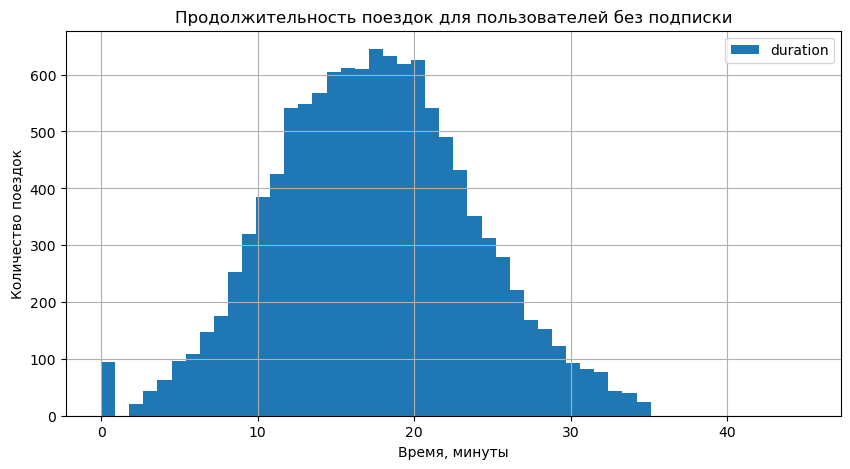

count    11568.0
mean        17.4
std          6.3
min          0.5
25%         13.0
50%         17.3
75%         21.6
max         34.9
Name: duration, dtype: float64

In [56]:
df_free_sub['duration'].hist(bins=50, range = (0, 45), figsize=(10, 5), legend=True, grid=True)
plt.title('Продолжительность поездок для пользователей без подписки')
plt.xlabel('Время, минуты')
plt.ylabel('Количество поездок')
plt.show()

df_free_sub['duration'].describe().round(1)

Продолжительность поездок пользователей без подписки в основном составляет от 5 до 30 минут. Максимальное время 35 минут, минимальное - 30 секунд. Среднее и медиана точны - 17 минут.

### Вывод

Объединили данные о пользователях, поездках и тарифах в один датафрейм - df.

Выделили два датафрейма на основе df:

- df_free_sub - Информация о пользователях без подписки
- df_ultra_sub - Информация о пользователях с подпиской

Визуализировали информацию о расстоянии и времени для каждого из тарифов.

Продолжительность поездок пользователей без подписки в основном составляет от 5 до 30 минут (максимальное время 35 минут), а пользователей с подпиской - 10-25 минут (максимальное время 41 минута).  

Дистанция поездок у пользователей без подписки в основном 1.7-5 км (максимальная дистанция 7.2 км), с подпиской - 2.5-4.5 км  (максимальная дистанция 5.7 км)

Можно сделать вывод, что пользователи с подпиской совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи без подписки.

## Этап 5. Подсчет выручки

In [57]:
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Продолжительность каждой поездки в каждой строке датафрейма для дальнейших расчетов округляем до следующего целого числа.

In [58]:
df['duration']=np.ceil(df['duration'])

In [59]:
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [60]:
# Проверка, что у каждого пользователя присутствует только один вариант подписки
df.groupby('user_id')['subscription_type'].nunique().value_counts()

1    1534
Name: subscription_type, dtype: int64

Создаем датафрейм с агрегированными данными о поездках на основе общего датафрейма df. 

В новых столбцах total_distance, total_duration и trip_count рассчитаем суммарное расстояние, суммарное время и количество поездок для каждого пользователя за каждый месяц

In [61]:
total_df=df.pivot_table(index=['month', 'user_id'],
                       values=['distance', 'duration', 'name', 'subscription_type'],
                       aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type': 'min'}
                       )
total_df.columns=['total_distance', 'total_duration', 'trip_count', 'subscription_type']

total_df=total_df.reset_index()

#total_df['total_duration']=np.ceil(total_df['total_duration'])

total_df.head(15)

,month,user_id,total_distance,total_duration,trip_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,3,3061.777147,13.0,1,ultra
2,1,5,3914.646990,13.0,1,ultra
3,1,7,6478.080979,28.0,2,ultra
4,1,12,3577.151148,33.0,1,ultra
5,1,13,6687.987446,42.0,2,ultra
6,1,14,7699.643820,35.0,2,ultra
7,1,15,4187.621459,39.0,1,ultra
8,1,20,3516.719208,29.0,1,ultra
9,1,22,3058.692225,13.0,1,ultra


Для подсчета выручки создадим функцию income_func и создадим новый столбец с данными о доходе. 

In [62]:
def income_func (row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['total_duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['total_duration'] + 50 * row['trip_count']
    else:
        return 'Другой тип подписки'

total_df['income'] = total_df.apply(income_func, axis=1)

total_df.head(10)

,month,user_id,total_distance,total_duration,trip_count,subscription_type,income
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,3,3061.777147,13.0,1,ultra,277.0
2,1,5,3914.646990,13.0,1,ultra,277.0
3,1,7,6478.080979,28.0,2,ultra,367.0
4,1,12,3577.151148,33.0,1,ultra,397.0
5,1,13,6687.987446,42.0,2,ultra,451.0
6,1,14,7699.643820,35.0,2,ultra,409.0
7,1,15,4187.621459,39.0,1,ultra,433.0
8,1,20,3516.719208,29.0,1,ultra,373.0
9,1,22,3058.692225,13.0,1,ultra,277.0


In [63]:
total_df['income'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: income, dtype: float64

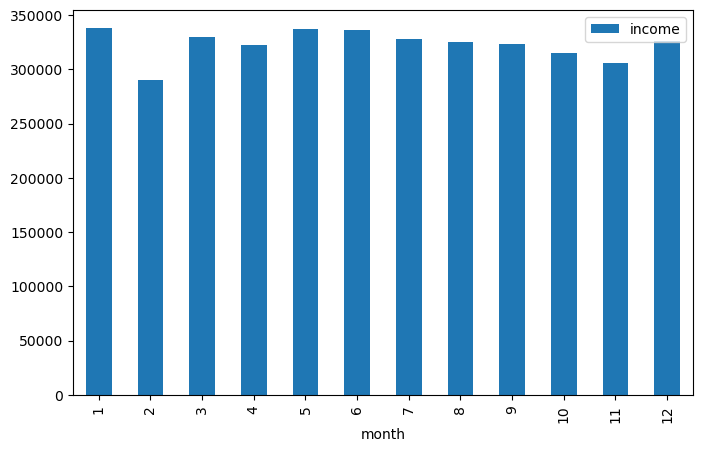

In [64]:
total_df.pivot_table(index='month', values='income', aggfunc='sum').plot.bar(figsize=(8, 5))
plt.show()

Наглядно рассмотрели суммарное распредение выручки по месяцам, самые "денежные" месяца оказались декабрь и январь, что странно, ведь в холодное время года самокаты не используются.

### Вывод

Создали датафрейм с агрегированными данными о поездках (total_df) на основе общего датафрейма df.

Рассчитали суммарное расстояние, суммарное время и количество поездок для каждого пользователя за каждый месяц

Добавили столбец с помесячной выручкой, которую принес каждый пользователь. 

## Этап 6. Проверка гипотез

### 6.1  Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании

**Гипотеза 1: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки**

Для проверки гипотезы воспользуемся двумя созданными датафреймами на 4 этапе с данными о пользователях с подпиской и без нее (df_ultra_sub и df_free_sub)

H0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free

H1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

Уровень статистической значимости (alpha) зададим 5%

In [65]:
ultra = df_ultra_sub['duration'] 

free = df_free_sub['duration']

alpha = 0.05

results = st.ttest_ind(ultra, free, alternative='greater')

print('средняя оценка времени с подпиской:', ultra.mean())
print('средняя оценка времени без подписки:', free.mean())

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу о равенстве среднего времени поездки с подпиской и без нее') 
else: 
    print('Не получилось отвергнуть нулевую гипотезу о равенстве среднего времени поездки с подпиской и без нее') 

средняя оценка времени с подпиской: 18.54198516280583
средняя оценка времени без подписки: 17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу о равенстве среднего времени поездки с подпиской и без нее


**Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу.** 

**Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.**

Визуализируем распределение продолжительности поездок по видам подписок и месяцам.

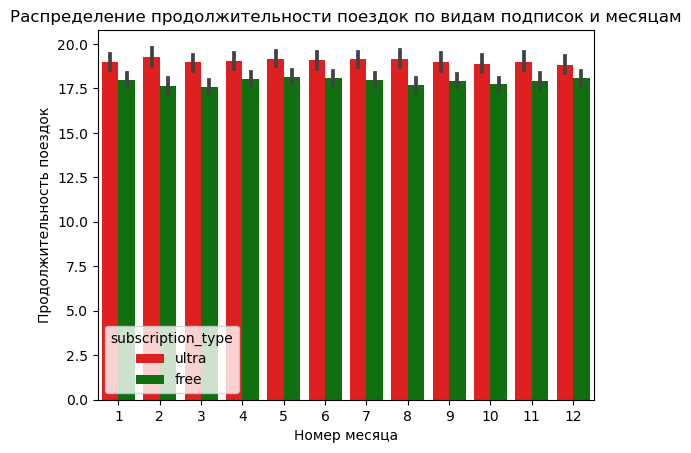

In [66]:
sub_duration=sns.barplot(
    x='month', 
    y='duration', 
    hue='subscription_type', 
    data=df,
    palette=['red', 'green'],
    )
sub_duration.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
sub_duration.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');


**Из графика видно, что в каждом месяце продолжительность поездок пользователей с подпиской больше, чем продолжительность поездок без подписки.**

### 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.  Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

**Гипотеза 2: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку**

H0: Расстояние (distance) проезжающее пользователи с подпиской ultra = 3130 метров

H1: Расстояние (distance) проезжающее пользователи с подпиской ultra < 3130 метров

Уровень статистической значимости (alpha) зададим 5%

In [67]:
distance_ultra = df_ultra_sub['distance']

interested_distance = 3130

alpha = 0.05

results = st.ttest_1samp(distance_ultra, interested_distance, alternative='less')

print('средняя оценка расстояния одной поездки с подпиской:', distance_ultra.mean())

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу: расстояние проезжающее пользователи с подпиской меньше 3130 метров') 
else: 
    print('Не получилось отвергнуть нулевую гипотезу') 

средняя оценка расстояния одной поездки с подпиской: 3115.4453880370247
p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


**После проверки гипотезы мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров за одну поездку**

### 6.3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

**Гипотеза 3: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки**

H0: Выручка  пользователей с подпиской ultra = выручка пользователей с подпиской free

H1: Выручка  пользователей с подпиской ultra > выручка  пользователей с подпиской free

Уровень статистической значимости (alpha) зададим 5%


In [68]:
ultra_income = total_df.loc[total_df['subscription_type'] == 'ultra', 'income'] 

free_income = total_df.loc[total_df['subscription_type'] == 'free', 'income'] 

alpha = 0.05

results = st.ttest_ind(ultra_income, free_income, alternative = 'greater')

print('средняя оценка помесячной выручки с подпиской:', ultra_income.mean())
print('средняя оценка помесячной выручки без подписки:', free_income.mean())

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выручка пользователей с подпиской больше чем выручка пользователей без нее')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

средняя оценка помесячной выручки с подпиской: 362.7921906022502
средняя оценка помесячной выручки без подписки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: выручка пользователей с подпиской больше чем выручка пользователей без нее


**Есть основания полагать, что помесячная выручка от пользователи с подпиской больше чем от пользователей без нее.** 

### 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Будем проверять гипотезу о равенстве средних для зависимых (парных) выборок

Гипотезы в таком случае будут сформулированы так: 

H0 :μ1 = μ2  
H1 :μ1 > μ2 

где μ1  и μ2  — средние значения  количества обращений в техподдержку до и после обновлений сервера. 

Метод, который необходимо использовать при сравнении scipy.stats.ttest_rel(), eму достаточно передать всего два параметра: наборы данных до и после изменений
Аргумент alternative укажу как alternative='greater', проверится правосторонняя альтернативная гипотеза о том, что истинное среднее генеральной совокупности до изменения больше, чем истинное среднее генеральной совокупности после изменения


## Этап 7. Выводы

**Проделанная работа:**
- загрузили 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках
- проверили данные на пропуски, их в таблицах нет
- привели столбец date в корректный формат
- добавили столбец month с номером месяца
- удалили строки-дубликаты из датафрейма с пользователями
- провели исследовательский анализ данных, в ходе которого было выявлено:
  - количество пользователей по городам распределено примерно одинаково.(лидер Пятигорск - 219 пользователей, меньше всего пользователей в Москве – 168)
  - пользователей без подписки больше - 54% от общего числа пользователей, с подпиской 699 пользователей, что соответственно является 46%.
  - средний возраст пользователя - 25 лет. В целом, пользователи приложения укладываются в промежуток от 20 до 30 лет.
  - в основном пользователи проезжают от 2.5 км до 3,8 км. Но есть короткая дистанция - 0.86 м., скорее всего связано с тем, что пользователь передумал брать самокат, либо самокат оказался неисправным.
  - в целом продолжительность поездки составляет 14 - 22 минуты. Но присутствует большое количество коротких поездок - по пол минуты, но скорее всего связано так же с тем что пользователь передумал брать самокат, либо самокат оказался неисправным.

- Объединили данные о пользователях, поездках и тарифах в один датафрейм - df:
  - Выделили два датафрейма на основе df: Информация о пользователях без подписки и Информация о пользователях с подпиской
  - По итогам исследования сделали промежуточный вывод о том, что пользователи с подпиской совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи без подписки.
- Рассчитали суммарное расстояние, суммарное время и количество поездок для каждого пользователя за каждый месяц
- Добавили столбец с помесячной выручкой, которую принес каждый пользователь. Выяснили что общая сумма выручки по месяцам распределена равномерно

**По результатам исследования выдвинули три гипотезы, проверили их и выдвинули результаты, которые помогут оптимизировать работу сервиса**

- Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки
- Мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров (оптимальное расстояние для износа самоката) за одну поездку
- Есть основания полагать, что помесячная выручка от пользователей с подпиской больше, чем от пользователей без нее.


**P.S. Попробую решить необязательное задание :)**

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<BarContainer object of 847 artists>

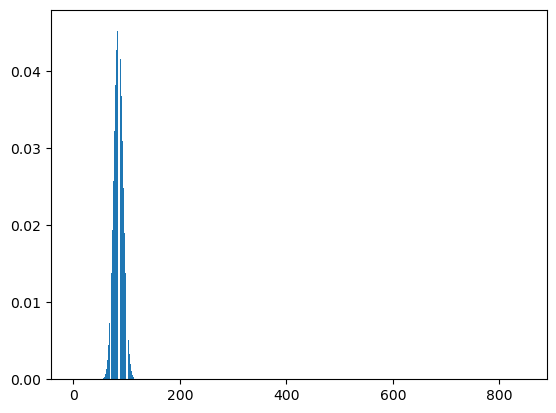

In [69]:
n = 846 # количество попыток, тоесть количество пользователей без подписки 846 

p = 0.1 # вероятность успеха 

distr = [] 

for k in range(0, n + 1): 

    choose = factorial(n) / (factorial(k) * factorial(n - k)) 

    prob = choose * p**k * (1 - p)**(n - k)  

    distr.append(prob)     

plt.bar(range(0, n + 1), distr) 

In [70]:
#мат ожидание n*p

distr = st.norm(100,84.6)  

p = 0.95 

result = distr.ppf(p) 

print(result) 

239.15461684009455


**По моим подсчетам для того, чтобы вероятность не выполнить план была примерно 5 % необходимо разослать минимум 239 промокодов для пользователей без оформленной подписки**